In [52]:
import pandas as pd 
import numpy as np
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [53]:
data = pd.read_excel('/home/lorenzo/PhD/PROMS/data/data_reg_anca.xls')

In [54]:
columns_preop = ['Uid', 'Sesso', 'Anni ricovero', 'Data operazione', 'Data dimissione',
           'Nome evento', 'Nome equipe', 'Procedura intervento', 'HHS Function PreOp',	
           'HHS Total PreOp', 'VAS PAIN risp PreOp','SF12 PhysicalScore PreOp',	
           'SF12 MentalScore PreOp', 'HOOSPS Total PreOp', 'BMI altezza risp PreOp',
           'BMI peso risp PreOp','BMI Total PreOp']
columns_3mon = ['Uid', 'Sesso', 'Anni ricovero', 'Data operazione', 'Data dimissione',
           'Nome evento', 'Nome equipe', 'Procedura intervento', 'HHS Function 3months',	
           'HHS Total 3months', 'VAS PAIN risp 3months','SF12 PhysicalScore 3months',	
           'SF12 MentalScore 3months', 'HOOSPS Total 3months', 'BMI altezza risp 3months',
           'BMI peso risp 3months','BMI Total 3months']
columns_6mon = ['Uid', 'Sesso', 'Anni ricovero', 'Data operazione', 'Data dimissione',
           'Nome evento', 'Nome equipe', 'Procedura intervento', 'HHS Function 6months',	
           'HHS Total 6months', 'VAS PAIN risp 6months','SF12 PhysicalScore 6months',	
           'SF12 MentalScore 6months', 'HOOSPS Total 6months', 'BMI altezza risp 6months',
           'BMI peso risp 6months','BMI Total 6months']

In [55]:
data = data.replace('#null', np.nan)

In [56]:
def from_obj_to_num(x):
    try:
        res = x.astype(float)
    except ValueError: 
        res = x 
    return res 

In [57]:
data = data.apply(from_obj_to_num)

In [58]:
data = data[~data['SF12 MentalScore 6months'].isna()]
data = data[~data['SF12 PhysicalScore 6months'].isna()]

In [59]:
#data = data[~data['VAS PAIN PREOP'].isna()]
data = data[~data['SF12 MentalScore PreOp'].isna()]
data = data[~data['SF12 PhysicalScore PreOp'].isna()]
data = data[~data['HOOSPS Total PreOp'].isna()]
data = data[~data['BMI altezza risp PreOp'].isna()]
data = data[~data['BMI peso risp PreOp'].isna()]

In [60]:
data['Data operazione'] = data['Data operazione'].str.replace('\s(00:00:00.0)','', regex = True)
data['Data operazione'] = pd.to_datetime(data['Data operazione'])
data['Data operazione'] = data['Data operazione'].dt.strftime('%Y/%m/%d')
mask_date = data['Data operazione'] <= '2021/05/05'
data_clean = data.loc[mask_date,:]

In [61]:
data_preop = data_clean.loc[:, columns_preop]

In [62]:
data_3month = pd.concat([data_clean[['Uid']], data_clean.filter(regex='3months', axis=1)], axis = 1)
data_6month = pd.concat([data_clean[['Uid']], data_clean.filter(regex='6months', axis=1)], axis = 1)
data_12month = pd.concat([data_clean[['Uid']], data_clean.filter(regex='12months', axis=1)], axis = 1)

In [63]:
def preproces_nomeevento(data_preop):
    data_preop['Nome evento'] = data_preop['Nome evento'].str.lower()#replace('\s+', ' ').value_counts()
    data_preop['Nome evento'] = data_preop['Nome evento'].str.replace('\n', '', regex = True)
    data_preop['Nome evento'] = data_preop['Nome evento'].str.replace(' +', ' ', regex = True)
    data_preop['Nome evento'] = data_preop['Nome evento'].str.replace('([a-z]+)(protesi)', r'\1 protesi',regex = True)
    return data_preop['Nome evento']

In [64]:
# lista_nome_evento = list(data_preop['Nome evento'].value_counts()[:5].index)
# with open('lista_nome_evento.pkl', 'wb') as f:
#     pickle.dump(lista_nome_evento, f)

In [65]:
with open('lista_nome_evento.pkl', 'rb') as f:
    lista_nome_evento = pickle.load(f)

In [66]:
def normalize_nomevento(x):
    if x in lista_nome_evento:
        nome_evento = x
    else:
        nome_evento = np.nan
    return nome_evento

In [67]:
data_preop['Nome evento'] = preproces_nomeevento(data_preop)

In [68]:
data_preop['Nome evento'] = data_preop['Nome evento'].apply(normalize_nomevento)

##### Binnarizzare Nome evento, Sesso, Nome equipe, (per ora eliminiamo procedura intervento)

In [69]:
data_preop['Procedura intervento'] = data_preop['Procedura intervento'].str.lower()

In [70]:
data_preop['Procedura intervento'] = data_preop['Procedura intervento'].str.replace('sx', 'sinistra')
data_preop['Procedura intervento'] = data_preop['Procedura intervento'].str.replace('dx', 'destra')

###### Procedura intervento --- embeddings

In [71]:
data_preop['Nome equipe'] = data_preop['Nome equipe'].str.lower().str.replace(' +', ' ',regex = True)

In [72]:
data_preop = data_preop[data_preop['Nome equipe'] != 'chirurgia del ginocchio i']

In [73]:
data_preop.Sesso = pd.get_dummies(data_preop.Sesso, drop_first= True) #0 F 1 M

In [74]:
data_preop = pd.concat([data_preop.drop(['Nome evento'], axis = 1), pd.get_dummies(data_preop['Nome evento'])], axis = 1)

In [75]:
data_preop = pd.concat([data_preop.drop(['Nome equipe'], axis = 1), pd.get_dummies(data_preop['Nome equipe'])], axis = 1)

### Splitting dei dati 

In [76]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(data_preop, groups=data_preop['Uid']))

In [77]:
train = data_preop.iloc[train_inds]
test = data_preop.iloc[test_inds]

In [78]:
columns_to_drop = ['Data operazione', 'Data dimissione', 'Procedura intervento', 'HHS Function PreOp', 'HHS Total PreOp']

In [79]:
train.drop(columns_to_drop, axis  = 1, inplace = True)
test.drop(columns_to_drop, axis = 1, inplace = True)

/home/lorenzo/anaconda3/envs/research/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [80]:
y_train_physical = data_6month.iloc[train_inds]['SF12 PhysicalScore 6months'] 
y_test_physical = data_6month.iloc[test_inds]['SF12 PhysicalScore 6months'] 

In [81]:
y_train_mental = data_6month.iloc[train_inds]['SF12 MentalScore 6months'] 
y_test_mental = data_6month.iloc[test_inds]['SF12 MentalScore 6months']

### Fare test sulla distribuzione del sesso e per fasce di eta' 

In [82]:
# dist_sesso = data_clean[['Sesso', 'SF12 MentalScore 6months']]

In [83]:
# sns.displot(data = dist_sesso, x = 'SF12 MentalScore 6months', hue = 'Sesso')

### training sul mental score

In [84]:
X_train = train.drop('Uid', axis = 1).values
X_test = test.drop('Uid', axis = 1).values

In [85]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

In [86]:
model = ElasticNet(alpha = 2.6)

In [90]:
model2 = ElasticNet()

In [87]:
cv = RepeatedKFold(n_splits=6, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train_physical, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

In [88]:
rmse = np.absolute(scores)
#rmse = np.sqrt(rmse)
print('Mean RMSE: %.3f (%.3f)' % (rmse.mean(), rmse.std()))

Mean RMSE: 9.394 (0.288)


In [89]:
model.fit(X_train, y_train_physical)

ElasticNet(alpha=2.6)

In [91]:
model2.fit(X_train, y_train_mental)

ElasticNet()

In [92]:
pred_physical = model.predict(X_test)

In [94]:
pred_mental = model2.predict(X_test)

/home/lorenzo/anaconda3/envs/research/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SF12 MentalScore 6months'>

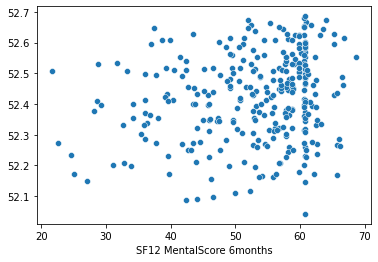

In [95]:
sns.scatterplot(y_test_mental,pred_test)

/home/lorenzo/anaconda3/envs/research/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SF12 PhysicalScore 6months'>

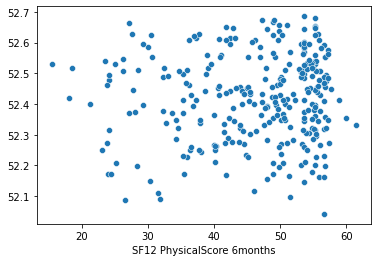

In [96]:
sns.scatterplot(y_test_physical,pred_test)

### filtrare gli outlier